<a href="https://colab.research.google.com/github/elisabethnetland/Labeling-Images-as-Edited-Using-CNN/blob/main/CNN_full_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from keras.wrappers.scikit_learn import KerasClassifier
from google.colab import files


In [ ]:
#renaming real and fake directories
real = "/content/drive/My Drive/archive/real_and_fake_face/training_real"
fake = "/content/drive/My Drive/archive/real_and_fake_face/training_fake"
#creating a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)
shuffle(fake_path)

In [ ]:
#Preprossesing the dataset; resize, grayscale, adding label
#Splitting 80:20 into training and test
img_size = 128
def create_training_data():
    training_data = []
    for img in tqdm(real_path[:865]):
        path = os.path.join(real, img)
        label = [0] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        training_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[:768]):
        path = os.path.join(fake, img)
        label = [1] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])

    shuffle(training_data)
    return(training_data)

#Creating a list of test data
def create_test_data():
    test_data = []
    for img in tqdm(real_path[865:]):
        path = os.path.join(real, img)
        label = [0] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        test_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[768:]):
        path = os.path.join(fake, img)
        label = [1] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        test_data.append([np.array(image), np.array(label)])

    shuffle(test_data)
    return(test_data)

train_data = create_training_data()
test_data = create_test_data()

100%|██████████| 192/192 [00:58<00:00,  3.30it/s]


In [ ]:
img_size = 128
#Seperating features and labels, to be able to feed into the model
train_img = []
train_lab = []
test_img = []
test_lab = []

for i in train_data:
    train_img.append(i[0])
    train_lab.append(i[1])
    
for i in test_data:
    test_img.append(i[0])
    test_lab.append(i[1])
    
#Reshape image 
train_img = np.array(train_img).reshape(-1, img_size, img_size, 1)
test_img = np.array(test_img).reshape(-1, img_size, img_size, 1)

#Divide by 255 to squish values to 0 - 1
train_img = train_img/255.0
train_lab = np.array(train_lab)

test_img = test_img/255.0
test_lab = np.array(test_lab)


In [ ]:
#Building our CNN model
model = Sequential()

#Layer 1
model.add(Conv2D(128,(3,3), activation="relu", input_shape=(128, 128, 1))) 
model.add(MaxPooling2D(pool_size=(2,2)))

#Layer 2
model.add(Conv2D(64,(3,3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.6))

#Layer 3
model.add(Conv2D(64,(3,3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))

#Layer 4
model.add(Conv2D(64,(3,3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.6))

#Fully Connected Layer
model.add(Flatten()) 
model.add(Dense(128))

#Output Sigmoid Layer
model.add(Dense(1, activation ="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

#Training the model
history = model.fit(train_img, train_lab, batch_size = 16, epochs = 70, verbose = 1, validation_split = 0.2)


Epoch 1/70
82/82 [==============================] - 1s 15ms/step - loss: 0.6937 - accuracy: 0.5237 - val_loss: 0.6929 - val_accuracy: 0.5046
Epoch 2/70
82/82 [==============================] - 1s 13ms/step - loss: 0.6927 - accuracy: 0.5299 - val_loss: 0.6956 - val_accuracy: 0.4771
Epoch 3/70
82/82 [==============================] - 1s 13ms/step - loss: 0.6898 - accuracy: 0.5459 - val_loss: 0.6943 - val_accuracy: 0.4771
Epoch 4/70
82/82 [==============================] - 1s 13ms/step - loss: 0.6903 - accuracy: 0.5352 - val_loss: 0.6970 - val_accuracy: 0.4771
Epoch 5/70
82/82 [==============================] - 1s 13ms/step - loss: 0.6880 - accuracy: 0.5475 - val_loss: 0.6945 - val_accuracy: 0.4862
Epoch 6/70
82/82 [==============================] - 1s 13ms/step - loss: 0.6888 - accuracy: 0.5467 - val_loss: 0.6953 - val_accuracy: 0.4771
Epoch 7/70
82/82 [==============================] - 1s 13ms/step - loss: 0.6855 - accuracy: 0.5613 - val_loss: 0.6972 - val_accuracy: 0.4771
Epoch 8/70
82

In [ ]:
model.save('my_cnn', save_format='tf')

model2 = keras.models.load_model('my_cnn') 
print(model2.summary())

INFO:tensorflow:Assets written to: my_cnn/assets
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_p

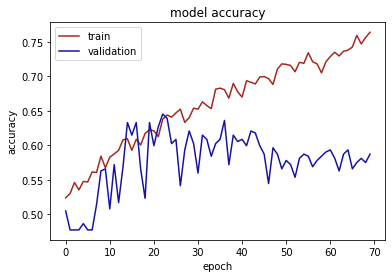

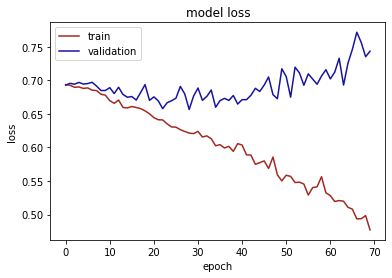

In [ ]:
# creating visual representation of training accuracy and loss
# summarize history for accuracy
plt.plot(history.history['accuracy'], color = '#a3281f')
plt.plot(history.history['val_accuracy'], color = '#1613a1')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color = '#a3281f')
plt.plot(history.history['val_loss'], color = '#1613a1')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Predictions
yhat_probs = model2.predict(test_img, verbose=0)
# predict crisp classes for test set
yhat_classes = model2.predict_classes(test_img, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

#Printing metrices
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_lab, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_lab, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_lab, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_lab, yhat_classes)
print('F1 score: %f' % f1)
average_precision = average_precision_score(test_lab, yhat_classes)
print('Average presicion/recall: %f' % average_precision)
 
# confusion matrix
matrix = confusion_matrix(test_lab, yhat_classes)
print(matrix)




Accuracy: 0.647059
Precision: 0.679104
Recall: 0.473958
F1 score: 0.558282
Average presicion/recall: 0.569416
[[173  43]
 [101  91]]
